<a href="https://colab.research.google.com/github/liuyao12/Ranger-Mish-ImageWoof-5/blob/master/Woof_128_twist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twist_s128_e2_e20

> Twist layer + Mish + MaxBlurPool + restrick

# setup and imports

In [2]:
!pip install git+https://github.com/ayasyrev/model_constructor

  Cloning https://github.com/ayasyrev/model_constructor to /tmp/pip-req-build-nqv25t9y
  Running command git clone -q https://github.com/ayasyrev/model_constructor /tmp/pip-req-build-nqv25t9y
  Created wheel for model-constructor: filename=model_constructor-0.1.1-cp36-none-any.whl size=21649 sha256=e70d51a113ad5c0494b214d95af9572fc980e9270446c060102ee9b3b569409f
  Stored in directory: /tmp/pip-ephem-wheel-cache-q1qj4bhy/wheels/5b/92/65/8093a307d5802f41f4a8776b40bc12b558e75a2a906ae8b683
Successfully built model-constructor


In [3]:
!pip install git+https://github.com/ayasyrev/imagenette_experiments

  Cloning https://github.com/ayasyrev/imagenette_experiments to /tmp/pip-req-build-_1cxeuaz
  Running command git clone -q https://github.com/ayasyrev/imagenette_experiments /tmp/pip-req-build-_1cxeuaz
     |████████████████████████████████| 143kB 6.9MB/s 
  Created wheel for imagenette-experiments: filename=imagenette_experiments-0.0.1-cp36-none-any.whl size=12379 sha256=8c6265c2486fa12c966ce6065f31ebcd566a30477240596e11f7c94be3c4b844
  Stored in directory: /tmp/pip-ephem-wheel-cache-vyvt3laj/wheels/af/99/98/2212941f45a18bf6d191f56c39e3569138414560c76defc0d4
Successfully built imagenette-experiments


In [0]:
from imagenette_experiments.train_utils import *

In [0]:
from kornia.contrib import MaxBlurPool2d

In [0]:
from fastai.basic_train import *
from fastai.vision import *
# from fastai.script import *
from model_constructor.net import *
from model_constructor.layers import SimpleSelfAttention, ConvLayer

# Twist

In [0]:
class ConvTwist(nn.Module):  # replacing 3x3 Conv2d
    def __init__(self, ni, nf, stride=1, init=0.7):
        super(ConvTwist, self).__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv_x = nn.Conv2d(ni, nf, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv_y = nn.Conv2d(ni, nf, kernel_size=3, stride=stride, padding=1, bias=False)
        self.symmetrize(self.conv_x.weight)  # make conv_x a "first-order operator" by symmetrizing it
        self.conv_y.weight.data = self.conv_x.weight.transpose(2,3).flip(3)  # make conv_y a 90 degree rotation of conv_x
        self.center_x = nn.Parameter(torch.Tensor(nf), requires_grad=True)
        self.center_y = nn.Parameter(torch.Tensor(nf), requires_grad=True)
        # self.center_x.data.uniform_(-init, init)
        # self.center_y.data.uniform_(-init, init)
        self.center_x.data.normal_(0, init)
        self.center_y.data.normal_(0, init)
        self.same = ni == nf and stride == 1

    def symmetrize(self, conv_wt):
        conv_wt.data = (conv_wt - conv_wt.flip(2).flip(3)) / 2
        
    def forward(self, inpt):
        out = self.conv(inpt)
        _, _, h, w = out.size()
        XX = torch.from_numpy(np.indices((1,h,w))[2]*2/w-1).type(out.dtype).to(out.device) + self.center_x.view(-1,1,1)
        YY = torch.from_numpy(np.indices((1,h,w))[1]*2/h-1).type(out.dtype).to(out.device) + self.center_y.view(-1,1,1)
        self.symmetrize(self.conv_x.weight)
        self.symmetrize(self.conv_y.weight)
        out += XX * self.conv_x(inpt) + YY * self.conv_y(inpt)
        # if self.same:
        #     out += inpt
        #     for _ in range(2):
        #         out += self.conv(out) + XX * self.conv_x(out) + YY * self.conv_y(out)
        #     out -= inpt
        return out

# ResBlock

In [0]:
class NewLayer(nn.Sequential):
    """Basic conv layers block"""
    def __init__(self, ni, nf, ks=3, stride=1,
            act=True,  act_fn=nn.ReLU(inplace=True),
            bn_layer=True, bn_1st=True, zero_bn=False,
            padding=None, bias=False, groups=1, **kwargs):

        if padding==None: padding = ks//2
#         layers = [('conv', nn.Conv2d(ni, nf, ks, stride=stride, 
#                 padding=padding, bias=bias, groups=groups))]
        if ks == 1:  layers = [('conv', nn.Conv2d(ni, nf, ks, stride=stride,bias=bias))]
        else:  layers = [('conv_twist', ConvTwist(ni, nf, stride=stride))]

        act_bn = [('act_fn', act_fn)] if act else []
        if bn_layer:
            bn = nn.BatchNorm2d(nf)
            nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
            act_bn += [('bn', bn)]
        if bn_1st: act_bn.reverse()
        layers += act_bn
        super().__init__(OrderedDict(layers))

In [0]:
class NewResBlock(Module):
    def __init__(self, expansion, ni, nh, stride=1, 
                 conv_layer=ConvLayer, act_fn=act_fn, bn_1st=True,
                 pool=nn.AvgPool2d(2, ceil_mode=True), sa=False,sym=False, zero_bn=True):
        nf,ni = nh*expansion,ni*expansion
        conv_layer = NewLayer
        self.reduce = noop if stride==1 else pool
        layers  = [(f"conv_0", conv_layer(ni, nh, 3, stride=stride, act_fn=act_fn, bn_1st=bn_1st)),
                   (f"conv_1", conv_layer(nh, nf, 3, zero_bn=zero_bn, act=False, bn_1st=bn_1st))
        ] if expansion == 1 else [
                   (f"conv_0",conv_layer(ni, nh, 1, act_fn=act_fn, bn_1st=bn_1st)),
                   (f"conv_1",conv_layer(nh, nh, 3, stride=1, act_fn=act_fn, bn_1st=bn_1st)), #!!!
                   (f"conv_2",conv_layer(nh, nf, 1, zero_bn=zero_bn, act=False, bn_1st=bn_1st))
        ]
        if sa: layers.append(('sa', SimpleSelfAttention(nf,ks=1,sym=sym)))
        self.convs = nn.Sequential(OrderedDict(layers))
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False, bn_1st=bn_1st)
        self.merge = act_fn

    def forward(self, x): 
        o = self.reduce(x)
        return self.merge(self.convs(o) + self.idconv(o))

In [0]:
# hide
NewResBlock(4, 64, 128)

# Model Constructor

In [0]:
pool = MaxBlurPool2d(3, True)

In [0]:
model = Net(c_out=10, layers=[3,4,6,3], expansion=4)

In [0]:
model.block = NewResBlock
model.pool = pool
model.stem_pool = pool
model.stem_sizes = [3,32,64,64]
model.act_fn= Mish()
model.sa = True

# Params

In [0]:
lr = 0.008
epochs = 5
moms = (0.95,0.95)
start_pct = 0.72
size=128
bs=32
mixup=0.2

# Lr find

In [0]:
learn = get_learn(model=model,size=size,bs=bs)

data path   /root/.fastai/data/imagewoof2
Learn path /root/.fastai/data/imagewoof2


In [0]:
learn.lr_find()

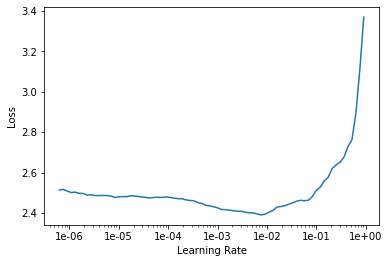

In [0]:
learn.recorder.plot()

# epochs 5 lr 0.008 750-754-749

In [0]:
lr = 4e-3
bs = 32
epochs = 200

In [15]:
learn = get_learn(model=model,size=size,bs=bs,mixup=mixup)
learn.fit_fc(epochs, lr, moms, start_pct)

data path   /root/.fastai/data/imagewoof2
Learn path /root/.fastai/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.031755,1.832395,0.403156,0.862051,01:55
1,1.865323,1.592740,0.515907,0.922372,01:55
2,1.692356,1.405653,0.614151,0.940188,01:55
3,1.618923,1.306222,0.659964,0.952405,01:55
4,1.519935,1.223134,0.698906,0.965640,01:55
5,1.449787,1.187948,0.719267,0.961822,01:54
6,1.404177,1.137573,0.728939,0.965131,01:54
7,1.351449,1.105645,0.757699,0.967422,01:54
8,1.327069,1.064088,0.765589,0.971240,01:54
9,1.306426,1.044834,0.778824,0.972003,01:53


Buffered data was truncated after reaching the output size limit.

In [70]:
for i in range(200):
    print('epoch {} {}'.format(i, learn.recorder.metrics[i][0].item()))

epoch 0 0.40315601229667664
epoch 1 0.515907347202301
epoch 2 0.6141511797904968
epoch 3 0.659964382648468
epoch 4 0.6989055871963501
epoch 5 0.7192670106887817
epoch 6 0.728938639163971
epoch 7 0.7576991319656372
epoch 8 0.7655892372131348
epoch 9 0.7788241505622864
epoch 10 0.7946042418479919
epoch 11 0.7869687080383301
epoch 12 0.8027487993240356
epoch 13 0.8032578229904175
epoch 14 0.8098753094673157
epoch 15 0.8096207976341248
epoch 16 0.8075846433639526
epoch 17 0.8256554007530212
epoch 18 0.8182743787765503
epoch 19 0.8302366733551025
epoch 20 0.8434716463088989
epoch 21 0.8187834024429321
epoch 22 0.8371086716651917
epoch 23 0.8159837126731873
epoch 24 0.8261644244194031
epoch 25 0.8371086716651917
epoch 26 0.8332909345626831
epoch 27 0.8350725173950195
epoch 28 0.8348180055618286
epoch 29 0.8437261581420898
epoch 30 0.8488165140151978
epoch 31 0.8340544700622559
epoch 32 0.8391448259353638
epoch 33 0.8381267786026001
epoch 34 0.8406718969345093
epoch 35 0.8480529189109802
epoc

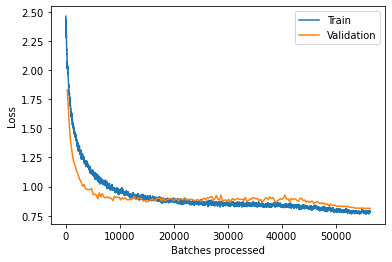

In [17]:
learn.recorder.plot_losses()

In [20]:
for name, param in learn.model.body.named_parameters():
    if 'center' in name:
        print(name, param.mean().item(), param.std().item())

l_0.bl_0.convs.conv_1.conv_twist.center_x 0.09526354819536209 1.0979540348052979
l_0.bl_0.convs.conv_1.conv_twist.center_y 0.05793863534927368 1.0744870901107788
l_0.bl_1.convs.conv_1.conv_twist.center_x 0.02706267684698105 0.81083744764328
l_0.bl_1.convs.conv_1.conv_twist.center_y -0.23288528621196747 0.8441702127456665
l_0.bl_2.convs.conv_1.conv_twist.center_x -0.06677819788455963 0.6632708311080933
l_0.bl_2.convs.conv_1.conv_twist.center_y -0.16185301542282104 0.6723574995994568
l_1.bl_0.convs.conv_1.conv_twist.center_x 0.019271723926067352 0.9966630339622498
l_1.bl_0.convs.conv_1.conv_twist.center_y -0.13794301450252533 1.0962557792663574
l_1.bl_1.convs.conv_1.conv_twist.center_x -0.07572091370820999 0.817357063293457
l_1.bl_1.convs.conv_1.conv_twist.center_y -0.02523697540163994 0.9151555299758911
l_1.bl_2.convs.conv_1.conv_twist.center_x 0.04342280328273773 0.6378564834594727
l_1.bl_2.convs.conv_1.conv_twist.center_y -0.029661109670996666 0.7416067123413086
l_1.bl_3.convs.conv_1.

Plotting the "centers" at the end of training — supposedly these are the points around which the `ConvTwist` is making a tiny rotation or dilation. I don't know what to make of these.

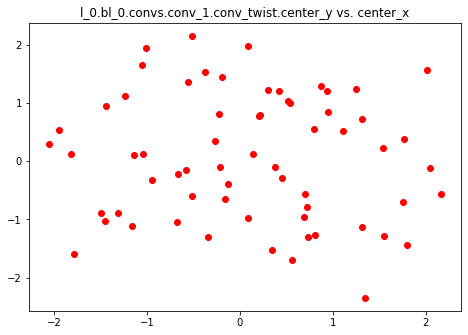

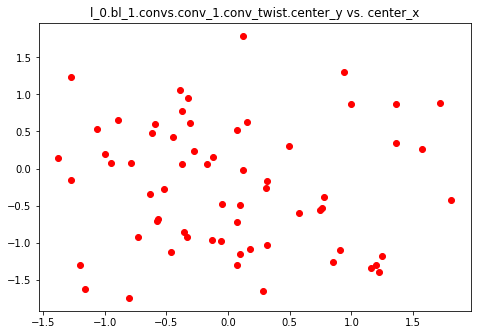

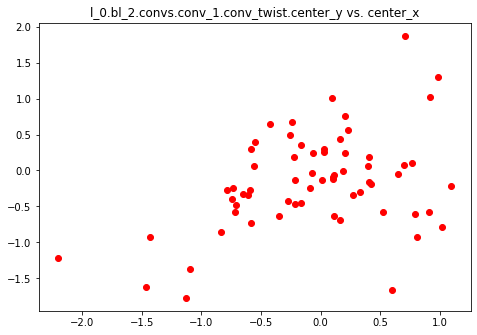

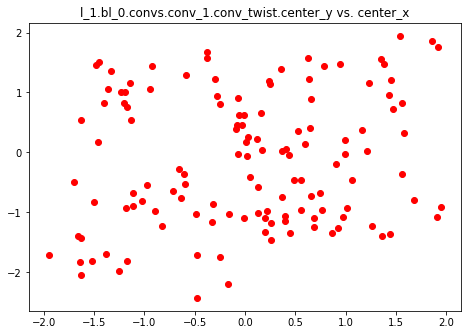

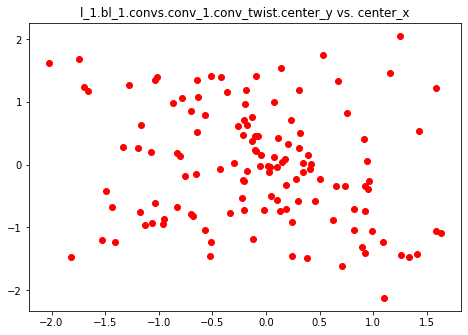

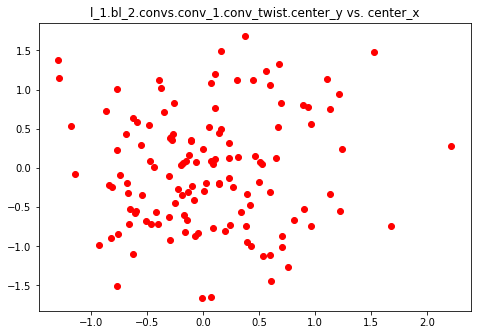

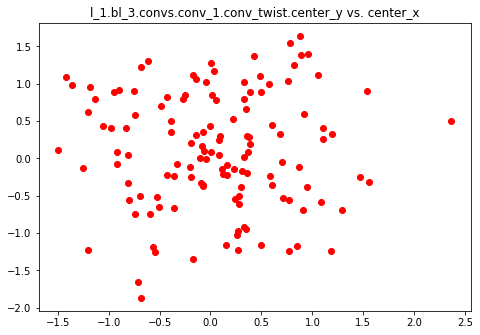

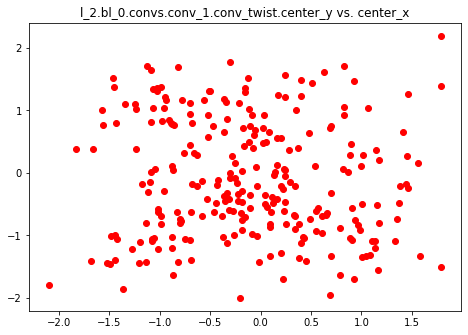

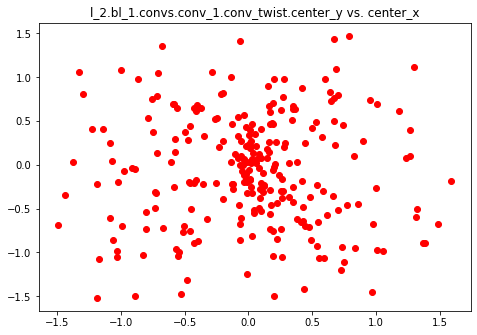

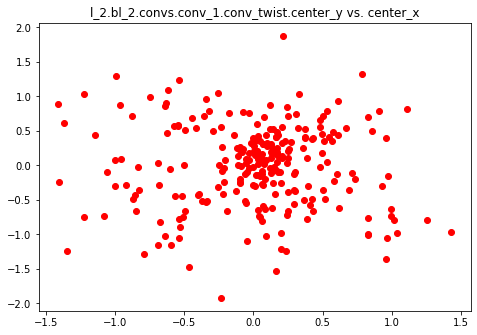

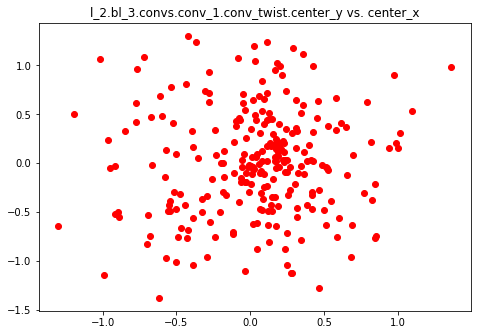

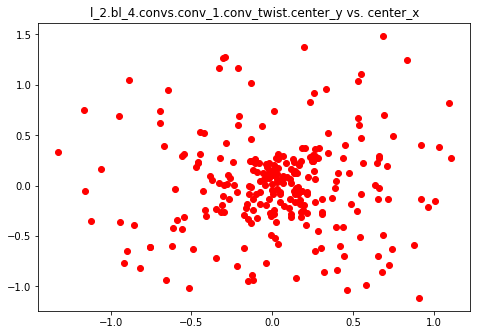

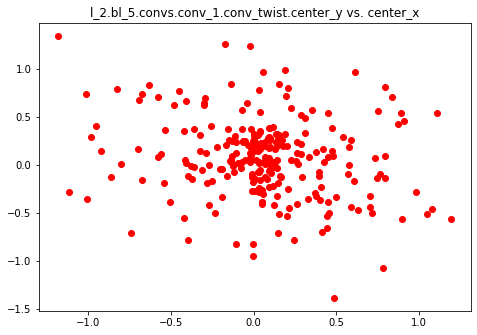

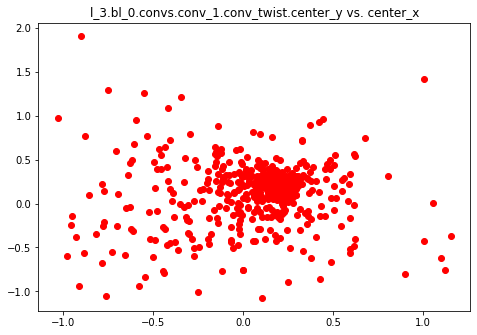

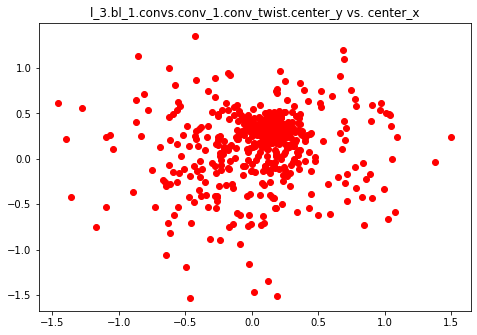

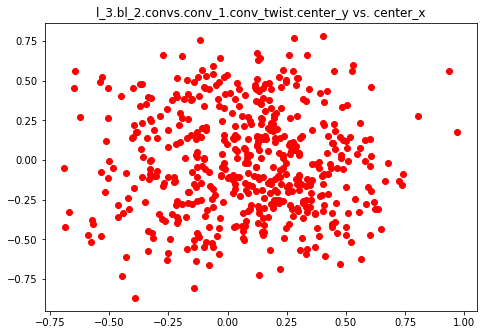

In [73]:
data = [None, None]
for name, param in learn.model.body.named_parameters():
    if 'center_x' in name:
        data[0] = param
    if 'center_y' in name:
        data[1] = param
        center_x = [x.item() for x in data[0]]
        center_y = [y.item() for y in data[1]]
        fig=plt.figure()
        ax=fig.add_axes([0,0,1,1])
        ax.scatter(center_x, center_y, color='r')
        ax.set_title(name + ' vs. center_x')
        plt.show()

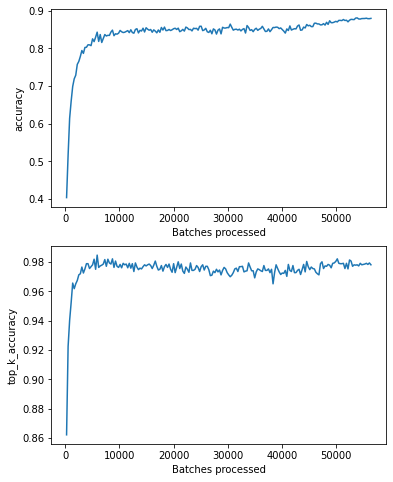

In [21]:
learn.recorder.plot_metrics()